# Trabalho 5
# Planejamento de Sistemas Elétricos - PPEE - UFJF
## Adriana Mendonça

Importação das bibliotecas necessárias

In [23]:
from cvxopt import matrix, solvers
import cvxopt
import numpy as np
import statistics
import math
from scipy import stats

In [24]:
!pip install PySDDP

In [25]:
from google.colab import drive, files
import os

#Montar o Google Drive no Colab com o nome gdrive

drive.mount('/content/gdrive')

# O comando abaixo mostra qual diretório você está trabalhando momento.
print( os.getcwd() )

Caminho_do_Arquivo = 'gdrive/My Drive/NewaveJuly2023/'
print( os.listdir(Caminho_do_Arquivo) )

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
['FORMAT.TMP', 'ELNINO.DAT', 'PENALID.DAT', 'GHMIN.DAT', 'NewaveMsgPortug.txt', 'ITAIPU.DAT', 'MENSAG.TMP', 'CLAST.DAT', 'ADTERM.DAT', 'GTMINPAT.DAT', 'CVAR.DAT', 'LOSS.DAT', 'ARQUIVOS.DAT', 'AGRINT.DAT', 'ENSOAUX.DAT', 'CDEFVAR.DAT', 'EXPH.DAT', 'C_ADIC.DAT', 'CASO.DAT', 'MANUTT.DAT', 'CONFT.DAT', 'CURVA.DAT', 'MODIF.DAT', 'DSVAGUA.DAT', 'BID.DAT', 'CONFHD.DAT', 'HIDR.DAT', 'EXPT.DAT', 'SISTEMA.DAT', 'TERM.DAT', 'SHIST.DAT', 'VAZPAST.DAT', 'PATAMAR.DAT', 'GTMIN_CCEE_072023.xlsx', 'VAZOES.DAT', 'REE.DAT', 'selcor.dat', 'RE.DAT', 'POSTOS.DAT', 'DGER.DAT', 'tecno.dat']


In [26]:
from PySDDP.Pen import Newave

PMOSET2023 = Newave(Caminho_do_Arquivo)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


Definir os dados de entrada para a otimização dos coeficientes ótimos do modelo autoregressivo.

In [35]:
# Dados de entrada
mes_alvo = 8
ano_inicial_analise = 1931
ano_alvo = 1950
ordem_modelo = 3
usina_alvo = 'furnas'

ano_inicial = ano_inicial_analise - 1931
anos_analise = ano_alvo-1931+1
Usina = PMOSET2023.confhd.get(usina_alvo)
#print('Usina', Usina['nome'])

**Função Objetivo (FOB)**

$		Min \sum_{i=1}^{n\_anos}  \left( Ε_{mês\_analisado,i} \right)^2 $

**sujeito a:**

$
\sum_{i=1931}^{n\_anos} \left( \sum_{j=mês\_analisado -1}^{mês\_analisado -n\_meses} \left(  Φ_{var} \cdot Z_{j}^{i} \right)  =  Z_{mês\_analisado}^{i} \right)
$

Sendo assim,
a dimensão das matrizes para a solução é determinada da seguinte forma:

P = [ N_anos + Ordem_meses X N_anos + Ordem_meses ]

q = [ 1 X N_anos + Ordem_meses ]

A = [ N_anos X N_ano + Ordem_meses ]

B = [ N_anos X 1 ]

Aeq = [ N_anos X N_anos + Ordem_meses ]

Beq = [ N_anos X 1 ]

In [36]:
if mes_alvo - ordem_modelo >= 1:

  recorte = Usina['vazoes'][ano_inicial:anos_analise,mes_alvo-ordem_modelo-1:mes_alvo-1]
  identidade = np.eye(anos_analise)
  Aeq = np.concatenate((recorte, identidade), axis = 1)
  Aeq = matrix(Aeq, tc='d')

else:

  recorte2 = Usina['vazoes'][ano_inicial:anos_analise,0:mes_alvo-1]
  recorte1 = Usina['vazoes'][ano_inicial:anos_analise,(11-(ordem_modelo-mes_alvo)):12]
  recorte = np.concatenate((recorte1, recorte2), axis = 1)
  identidade = np.eye(anos_analise)
  Aeq = np.concatenate((recorte, identidade), axis = 1)
  Aeq = matrix(Aeq, tc='d')


Beq = np.array(Usina['vazoes'][ano_inicial:anos_analise,mes_alvo-1:mes_alvo])
Beq = matrix(Beq, tc='d')

q = np.zeros((1,anos_analise+ordem_modelo))
q = matrix(q, tc='d')
P = 2*np.eye(anos_analise+ordem_modelo)
for num1 in range(ordem_modelo):
  P[num1][num1] = 0
P = matrix(P, tc='d')

A = np.zeros((anos_analise,anos_analise+ordem_modelo))
B = np.zeros((anos_analise,1))
A = matrix(A, tc='d')
B = matrix(B, tc='d')

solvers.options['show_progress'] = False
abstol = 1e-9
reltol = 1e-9
sol = cvxopt.solvers.qp(P, q.T, A, B, Aeq, Beq, abstol=abstol, reltol=reltol)

Prints das soluções:

In [29]:
mes = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
kk = 1 + ordem_modelo
kk_2 = 0
teste = ordem_modelo
for num1 in range(ordem_modelo):
  if mes_alvo - ordem_modelo >= 1:
    print('Parâmetro referente ao mês', mes[mes_alvo-kk],': ', end="")
    print(np.round(sol['x'][num1],6))
    kk = kk-1
  else:
    if mes_alvo - teste < 1:
      print('Parâmetro referente ao mês', mes[11-np.abs(teste-mes_alvo)],': ', end="")
      print(np.round(sol['x'][num1],6))
      #kk_2 = kk_2-1
      teste = teste - 1
    else:
      print('Parâmetro referente ao mês', mes[kk_2],': ', end="")
      print(np.round(sol['x'][num1],6))
      kk_2 = kk_2+1


Parâmetro referente ao mês maio : 0.009222
Parâmetro referente ao mês junho : 0.170951
Parâmetro referente ao mês julho : 0.60054


In [30]:
kk = 0
print('Erros quadráticos:')
for num1 in range(anos_analise):
  print('Erro de',mes[mes_alvo-1],'/',1931 + num1, ': ', end="")
  print(sol['x'][ordem_modelo+kk])
  kk = kk+1

Erros quadráticos:
Erro de agosto / 1931 : -41.28847952559505
Erro de agosto / 1932 : -5.302798567634671
Erro de agosto / 1933 : 62.49691941232288
Erro de agosto / 1934 : 9.617028294393407
Erro de agosto / 1935 : 11.697187437218007
Erro de agosto / 1936 : 52.49538137542582
Erro de agosto / 1937 : -23.54532582256378
Erro de agosto / 1938 : 59.191307254114
Erro de agosto / 1939 : 5.664037232737592
Erro de agosto / 1940 : -16.571631950028525
Erro de agosto / 1941 : -22.826557957236155
Erro de agosto / 1942 : -24.8730508711555
Erro de agosto / 1943 : 38.43687610222685
Erro de agosto / 1944 : 3.252243639484161
Erro de agosto / 1945 : -51.597278736388596
Erro de agosto / 1946 : -13.253961210884995
Erro de agosto / 1947 : -18.75749990672262
Erro de agosto / 1948 : 9.453904370918114
Erro de agosto / 1949 : -8.080858438127963
Erro de agosto / 1950 : 20.650359018072884


In [31]:
erro_modulo = np.abs(sol['x'][ordem_modelo:len(sol['x'])])
media = np.mean(erro_modulo)
print('Média dos erros: ', end="")
print(round(media,8))

med = np.zeros((len(sol['x'][ordem_modelo:len(sol['x'])])))
for num1 in range(len(sol['x'][ordem_modelo:len(sol['x'])])):
  med[num1] = media


Média dos erros: 24.95263436


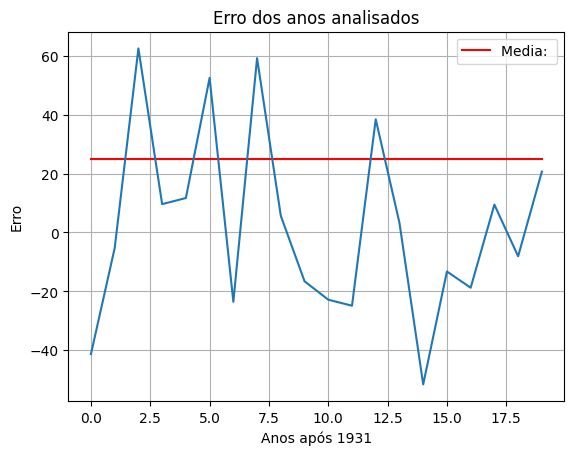

In [32]:
import matplotlib.pyplot as plt
plt.plot(med,'red')
plt.plot(sol['x'][ordem_modelo:len(sol['x'])])
plt.ylabel('Erro')
plt.xlabel('Anos após 1931')
plt.title('Erro dos anos analisados')
plt.legend(['Media: '])
plt.grid()